# 1. Déploiement de la solution en local

## 1.1 Environnement de travail

Google colab


In [1]:
# to import files / data from Google Drive
from google.colab import drive
drive.mount("/drive")

Mounted at /drive


## 1.2 Installation des packages

<u>On installe ensuite à l'aide de la commande **pip** <br />
les packages qui nous seront nécessaires</u> :

In [2]:
!pip install Pandas pillow tensorflow pyspark pyarrow  # The exclamation mark at the start of a cell allows to run a shell command, and pip is the Python package installer that allows to install Python libraries.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=f31cc33a1e453d16c8d6a41543954f5d00895acc63619f60fa3b28cf5afcb81d
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


## 1.3 Import des librairies

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

## 1.4 Définition des PATH pour charger les images <br /> et enregistrer les résultats

Dans cette version locale nous partons du principe que les données <br />
sont stockées dans le même répertoire que le notebook.<br />
Nous n'utilisons qu'un extrait de **30 images** à traiter dans cette <br />
première version en local.<br />
L'extrait des images à charger est stockée dans le dossier **Test1**.<br />
Nous enregistrerons le résultat de notre traitement <br />
dans le dossier "**Results_Local**"

In [4]:
#PATH = os.getcwd()
PATH = "/drive/My Drive/AI/OC/P8/"
print("PATH :", PATH)

PATH_Data = PATH + '/data/Test1'
PATH_Result = PATH + '/data/Results_local'

# Create local directories to save data
os.makedirs(PATH_Data, exist_ok=True)
os.makedirs(PATH_Result, exist_ok=True)

print('PATH:        ' +
      PATH + '\nPATH_Data:   ' +
      PATH_Data + '\nPATH_Result: ' + PATH_Result)

PATH : /drive/My Drive/AI/OC/P8/
PATH:        /drive/My Drive/AI/OC/P8/
PATH_Data:   /drive/My Drive/AI/OC/P8//data/Test1
PATH_Result: /drive/My Drive/AI/OC/P8//data/Results_local


## 1.5 Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**. <br />
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur <br />
dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

<u>Ici nous créons une session spark en spécifiant dans l'ordre</u> :
 1. un **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**P8**"
 2. que l'application doit s'exécuter **localement**. <br />
   Nous ne définissons pas le nombre de cœurs à utiliser (comme .master('local[4]) pour 4 cœurs à utiliser), <br />
   nous utiliserons donc tous les cœurs disponibles dans notre processeur.<br />
 3. une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** <br />
   que nous utiliserons pour enregistrer et charger le résultat de notre travail.
 4. vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle

In [5]:
spark = (SparkSession
         .builder
         .appName('P8')
         .master('local')
         .config("spark.sql.parquet.writeLegacyFormat", 'true')
         .getOrCreate()
         )

<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [6]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [7]:
spark

## 1.6 Traitement des données

<u>Dans la suite de notre flux de travail, <br />
nous allons successivement</u> :
1. Préparer nos données
    1. Importer les images dans un dataframe **pandas UDF**
    2. Associer aux images leur **label**
    3. Préprocesser en **redimensionnant nos images pour <br />
       qu'elles soient compatibles avec notre modèle**
2. Préparer notre modèle
    1. Importer le modèle **MobileNetV2**
    2. Créer un **nouveau modèle** dépourvu de la dernière couche de MobileNetV2
3. Définir le processus de chargement des images et l'application <br />
   de leur featurisation à travers l'utilisation de pandas UDF
3. Exécuter les actions d'extraction de features
4. Enregistrer le résultat de nos actions
5. Tester le bon fonctionnement en chargeant les données enregistrées




### 1.6.1 Chargement des données

Les images sont chargées au format binaire, ce qui offre, <br />
plus de souplesse dans la façon de prétraiter les images.

Avant de charger les images, nous spécifions que nous voulons charger <br />
uniquement les fichiers dont l'extension est **jpg**.

Nous indiquons également de charger tous les objets possibles contenus <br />
dans les sous-dossiers du dossier communiqué.

In [8]:
images = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load(PATH_Data)

<u>Affichage des 5 premières images contenant</u> :
 - le path de l'image
 - la date et heure de sa dernière modification
 - sa longueur
 - son contenu encodé en valeur hexadécimal

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [9]:
images = images.withColumn('label', element_at(split(images['path'], '/'), -2))
print(images.printSchema())
print(images.select('path', 'label').show(5, False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------------------------------+------------------+
|path                                                                    |label             |
+------------------------------------------------------------------------+------------------+
|file:/drive/My Drive/AI/OC/P8/data/Test1/Watermelon/r_171_100.jpg       |Watermelon        |
|file:/drive/My Drive/AI/OC/P8/data/Test1/Watermelon/152_100.jpg         |Watermelon        |
|file:/drive/My Drive/AI/OC/P8/data/Test1/Raspberry/111_100.jpg          |Raspberry         |
|file:/drive/My Drive/AI/OC/P8/data/Test1/Apple Golden 1/105_100.jpg     |Apple Golden 1    |
|file:/drive/My Drive/AI/OC/P8/data/Test1/Apple Crimson Snow/r_43_100.jpg|Apple Crimson Snow|
+-------------------------------------

### 1.6.2 Préparation du modèle

Je vais utiliser la technique du **transfert learning** pour extraire les features des images.<br />
J'ai choisi d'utiliser le modèle **MobileNetV2** pour sa rapidité d'exécution comparée <br />
à d'autres modèles comme *VGG16* par exemple.

Pour en savoir plus sur la conception et le fonctionnement de MobileNetV2, <br />
je vous invite à lire [cet article](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c).

<u>Voici le schéma de son architecture globale</u> : 

![Architecture de MobileNetV2](img/mobilenetv2_architecture.png)

Il existe une dernière couche qui sert à classer les images <br />
selon 1000 catégories que nous ne voulons pas utiliser.<br />
L'idée dans ce projet est de récupérer le **vecteur de caractéristiques <br />
de dimensions (1,1,1280)** qui servira, plus tard, au travers d'un moteur <br />
de classification à reconnaitre les différents fruits du jeu de données.

Comme d'autres modèles similaires, **MobileNetV2**, lorsqu'on l'utilise <br />
en incluant toutes ses couches, attend obligatoirement des images <br />
de dimension (224,224,3). Nos images étant toutes de dimension (100,100,3), <br />
nous devrons simplement les **redimensionner** avant de les confier au modèle.

<u>Dans l'odre</u> :
 1. Nous chargeons le modèle **MobileNetV2** avec les poids **précalculés** <br />
    issus d'**imagenet** et en spécifiant le format de nos images en entrée
 2. Nous créons un nouveau modèle avec:
  - <u>en entrée</u> : l'entrée du modèle MobileNetV2
  - <u>en sortie</u> : l'avant dernière couche du modèle MobileNetV2

In [10]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

14536120/14536120 [==============================] - 0s 0us/step


In [11]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle où nous constatons <br />
que <u>nous récupérons bien en sortie un vecteur de dimension (1, 1, 1280)</u> :

In [12]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. <br />
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser <br />
ensuite les poids aux différents workeurs.

In [13]:
brodcast_weights = sc.broadcast(new_model.get_weights())

<u>Mettons cela sous forme de fonction</u> :

In [14]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                      outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### 1.6.3 Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

Ce notebook définit la logique par étapes, jusqu'à Pandas UDF.

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [15]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)


def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)  # yield == https://www.geeksforgeeks.org/python-yield-keyword/ - fct returns a generator (and we can iterate on it)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### 1.6.4 Exécution des actions d'extraction de features

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), <br />
peuvent rencontrer des erreurs de type Out Of Memory (OOM).<br />
Si vous rencontrez de telles erreurs dans la cellule ci-dessous, <br />
essayez de réduire la taille du lot Arrow via 'maxRecordsPerBatch'

Je n'utiliserai pas cette commande dans ce projet <br />
et je laisse donc la commande en commentaire.

In [16]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.<br />
<u>REMARQUE</u> : Cela peut prendre beaucoup de temps, tout dépend du volume de données à traiter. <br />

Notre jeu de données de **Test** contient **22819 images**. <br />
Cependant, dans l'exécution en mode **local**, <br />
nous <u>traiterons un ensemble réduit de **330 images**</u>.

In [17]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                            )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [18]:
print(PATH_Result)

/drive/My Drive/AI/OC/P8//data/Results_local


<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [19]:
# features_df.write.mode("overwrite").parquet(PATH_Result)

## 1.7 PCA

<u>On effectue une réduction de dimension avec une ACP pour séparer les images en utilisant les features extraites</u> :

In [24]:
from pyspark.ml.feature import StandardScaler, PCA
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.PCA.html

from pyspark.ml.functions import array_to_vector, vector_to_array

In [ ]:
features_df.show(2)

In [30]:
%%time
# scale ? or StandardScaler ?? TODO check

def scale_features(df_features):
  """
  Returns the DataFrame entered as a parameter scaled using a Standard Scaler

  :param df_features: (pyspark.sql.dataframe.DataFrame)
  :return:
  :rtype: pyspark.sql.dataframe.DataFrame
  """

  # transform array to vector
  df_features = df_features.withColumn('features', array_to_vector('features'))

  # scale data
  scaler = StandardScaler(
      inputCol = 'features',
      outputCol = 'scaled_features',
      withMean = True,
      withStd = True
  ).fit(df_features)
  df_features_scaled = scaler.transform(df_features)

  return df_features_scaled

features_df_scaled = scale_features(features_df)

In [31]:
features_df.show(2)
features_df_scaled.show(2)
features_df_pca.show(2)
features_df_pca_.show(2)

# features_df_pca.select('label').show(2)

+--------------------+------------------+--------------------+
|                path|             label|            features|
+--------------------+------------------+--------------------+
|file:/drive/My Dr...|Apple Crimson Snow|[0.0, 0.0, 0.0, 0...|
|file:/drive/My Dr...|        Watermelon|[0.012825567, 0.4...|
+--------------------+------------------+--------------------+
only showing top 2 rows

+--------------------+------------------+--------------------+--------------------+
|                path|             label|            features|     scaled_features|
+--------------------+------------------+--------------------+--------------------+
|file:/drive/My Dr...|Apple Crimson Snow|[0.0,0.0,0.0,0.0,...|[-0.7350413648458...|
|file:/drive/My Dr...|        Watermelon|[0.01282556727528...|[-0.7139695350735...|
+--------------------+------------------+--------------------+--------------------+
only showing top 2 rows

+--------------------+------------------+--------------------+------

<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [32]:
features_df_pca.write.mode("overwrite").parquet(PATH_Result) 

<u>Graphique de la variance expliquée par l'ACP</u> :

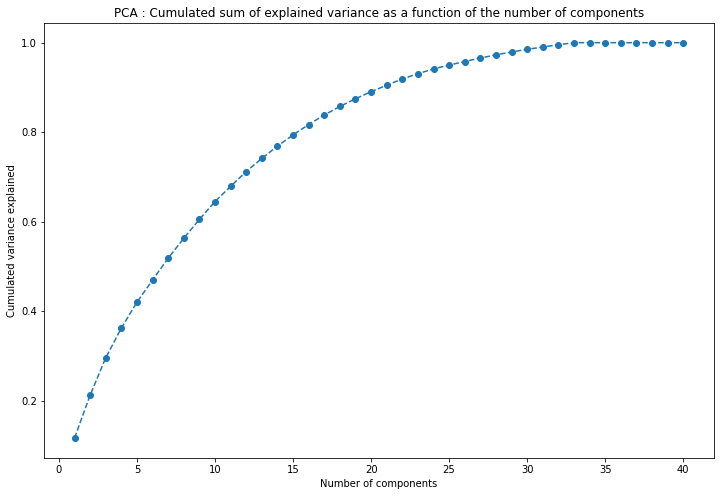

In [33]:
import matplotlib.pyplot as plt


def display_PySpark_pca_variance_cumsum(pca_fitted):
    """
    :param pca_fitted:
    :return:
    """
    plt.figure(figsize=(12, 8))
    plt.title('PCA : Cumulated sum of explained variance as a function of the number of components')
    plt.xlabel('Number of components')
    plt.ylabel('Cumulated variance explained')

    plt.plot(np.arange(start=1, stop=pca_fitted.getK() + 1),
             np.cumsum(pca_fitted.explainedVariance), marker = 'o', linestyle='--') # cumValues = pca_model.explainedVariance.cumsum()

display_PySpark_pca_variance_cumsum(pca_model)

## 1.8 Chargement des données enregistrées et validation du résultat

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [34]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>On affiche les 5 premières lignes du DataFrame</u> :

In [35]:
df.head()

,path,label,features,pca_features
0,file:/drive/My Drive/AI/OC/P8/data/Test1/Apple...,Apple Crimson Snow,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.8282229900360107, ...","[7.623144376299502, 4.926324016170813, 4.20514..."
1,file:/drive/My Drive/AI/OC/P8/data/Test1/Water...,Watermelon,"[0.01282556727528572, 0.4700985848903656, 0.0,...","[-11.049038780238458, -11.189032216304824, 6.0..."
2,file:/drive/My Drive/AI/OC/P8/data/Test1/Apple...,Apple Red Yellow 1,"[0.37628528475761414, 0.035564910620450974, 0....","[10.306888619480848, -2.384498569050896, -7.86..."
3,file:/drive/My Drive/AI/OC/P8/data/Test1/Tomat...,Tomato Yellow,"[0.0, 0.7056543827056885, 0.0, 0.0, 0.0, 2.384...","[10.203155492101946, 6.450768106599577, -5.278..."
4,file:/drive/My Drive/AI/OC/P8/data/Test1/Apple...,Apple Golden 1,"[0.0, 0.003275326220318675, 1.0620614290237427...","[0.19016565809646457, -6.611334741220691, 11.9..."


<u>On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280</u> :

In [36]:
df.loc[0, 'features'].shape

(1280,)

Nous venons de valider le processus sur un jeu de données allégé en local <br />
où nous avons simulé un cluster de machines en répartissant la charge de travail <br />
sur différents cœurs de processeur au sein d'une même machine.

Nous allons maintenant généraliser le processus en déployant notre solution <br />
sur un réel cluster de machines et nous travaillerons désormais sur la totalité <br />
des 22819 images de notre dossier "Test".